# Analiza wrażliwości

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from simulation import run_simulation

%matplotlib inline

In [2]:
n_simulations = 1000

In [3]:
results_normal, _ = run_simulation(n_simulations=n_simulations)

In [35]:
print("średni dochód: " + str(results_normal.mean()))
print("odchylenie z dochodu: " + str(results_normal.std()))

średni dochód: 174.94766190097428
odchylenie z dochodu: 108.47388042483627


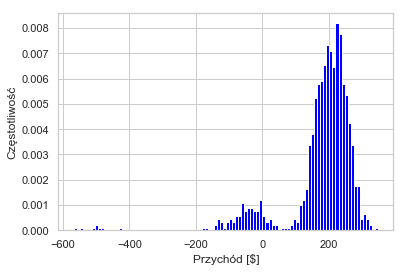

In [36]:
plt.hist(results_normal, bins=100, density = True, color = 'blue')
plt.ylabel("Częstotliwość")
plt.xlabel("Przychód [$]")
plt.show()

# Strzelaniny

In [31]:
results_faster_shootout, _ = run_simulation(n_simulations=n_simulations, p_lost_everything=0.05)
results_normal_shootout, _ = run_simulation(n_simulations=n_simulations)
results_slower_shootout, _ = run_simulation(n_simulations=n_simulations, p_lost_everything=0.01)

In [32]:
print("średnia:")
print("szybciej strzelaniny: " + str(results_faster_shootout.mean()))
print("normalne strzelaniny: " + str(results_normal_shootout.mean()))
print("wolniejsze strzelaniny: " + str(results_slower_shootout.mean()))

średnia:
szybciej strzelaniny: 153.26476442181885
normalne strzelaniny: 180.76643176589496
wolniejsze strzelaniny: 184.27200259911163


<Figure size 1440x720 with 0 Axes>

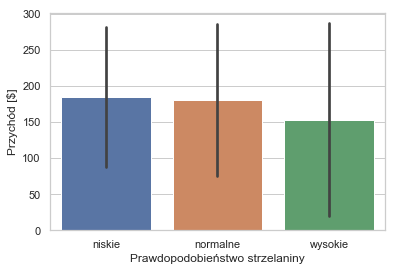

In [47]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Prawdopodobieństwo strzelaniny": 
            ["niskie"] * n_simulations + 
            ["normalne"] * n_simulations + 
            ["wysokie"] * n_simulations,
        "Przychód [$]": np.concatenate((results_slower_shootout, results_normal_shootout, results_faster_shootout), axis=0)
    }
)
ax = sns.barplot(x="Prawdopodobieństwo strzelaniny", y="Przychód [$]", data=df_to_plot, ci="sd")
plt.show()

## Ile barmanów zatrudnić

In [37]:
max_male = 10
max_female = 10

male_bartenders = np.arange(0, max_male+1)
female_bartenders = np.arange(0, max_female+1)
bartender_results = np.zeros((max_male+1, max_female+1))

for i in range(bartender_results.shape[0]):
    for j in range(bartender_results.shape[1]):
        # creating unique combination of male and female bartenders
        barternders = [False] * male_bartenders[i] + [True] * female_bartenders[j]
        #running simulation
        results, _ = run_simulation(n_simulations=n_simulations, bartenders=barternders)
        
        #appending results
        bartender_results[i, j] = results.mean()

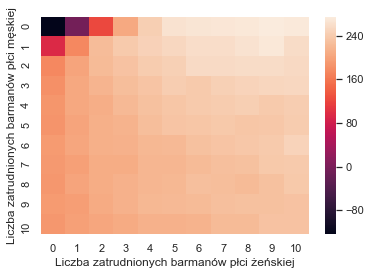

In [38]:
ax = sns.heatmap(bartender_results)
plt.ylabel("Liczba zatrudnionych barmanów płci męskiej")
plt.xlabel("Liczba zatrudnionych barmanów płci żeńskiej")
plt.show()

In [39]:
df = pd.DataFrame.from_dict(bartender_results).T

In [40]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,-123.808928,95.116004,176.201555,183.135418,188.468495,186.700844,192.499551,191.862136,190.118864,192.554746,189.178016
1,-6.588568,175.982068,202.278683,204.778315,205.268229,201.709692,203.212235,198.138206,202.470425,195.650316,197.160671
2,122.455036,225.917678,223.652178,218.302433,211.372316,213.554669,213.524209,209.542594,209.164025,207.705371,203.836213
3,206.293698,238.732699,231.678900,227.150110,222.913356,216.719170,214.897610,210.036777,214.236553,214.444428,208.058526
4,244.332596,247.230000,240.294611,233.662334,230.423965,226.229902,221.302449,219.043296,219.625411,220.590538,215.075039
5,264.853055,252.819836,246.130778,242.909009,234.610960,232.747739,222.486841,219.231785,220.963298,221.905428,215.046145
6,267.133456,260.273395,255.836403,240.023436,238.723475,235.445021,230.403058,223.850024,228.367373,223.696624,215.847799
7,269.023289,260.091869,256.292216,245.141896,241.191567,237.651423,232.572014,229.151645,227.344125,228.769833,223.996401
8,270.911032,264.243635,257.643001,249.310530,243.546429,235.500452,235.588433,229.968907,223.873671,230.254203,223.693026
9,274.439316,270.948228,258.727198,251.667132,239.022841,236.576770,239.421390,238.029665,229.650011,230.371096,231.193218


In [43]:
df.loc[:,0] / df.loc[:,2]

0    -0.702655
1    -0.032572
2     0.547524
3     0.890429
4     1.016804
5     1.076066
6     1.044157
7     1.049674
8     1.051498
9     1.060729
10    1.071258
dtype: float64

In [46]:
df.loc[:,0] / df.loc[:,3]

0    -0.676051
1    -0.032174
2     0.560942
3     0.908182
4     1.045665
5     1.090339
6     1.112947
7     1.097419
8     1.086641
9     1.090485
10    1.077630
dtype: float64

## Jaka strategia cenowa

In [8]:
results_expensive, _ = run_simulation(n_simulations=n_simulations, drink_price=4, patience_threshold=10)
results_cheap, _ = run_simulation(n_simulations=n_simulations)
results_super_cheap, _ = run_simulation(
    n_simulations=n_simulations,
    drink_price=1,
    patience_threshold=20,
    customer_lambda=10)

In [9]:
print("średnia:")
print("droższe drinki: " + str(results_expensive.mean()))
print("tańsze drinki: " + str(results_cheap.mean()))
print("super tanie drinki: " + str(results_super_cheap.mean()))

print("\nodchylenie:")
print("droższe drinki: " + str(results_expensive.std()))
print("tańsze drinki: " + str(results_cheap.std()))
print("super tanie drinki: " + str(results_super_cheap.std()))

średnia:
droższe drinki: 333.3012707517266
tańsze drinki: 179.59053343967267
super tanie drinki: -48.12108658340554

odchylenie:
droższe drinki: 136.5362613551037
tańsze drinki: 106.46540706701437
super tanie drinki: 144.72680224169088


D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1440x720 with 0 Axes>

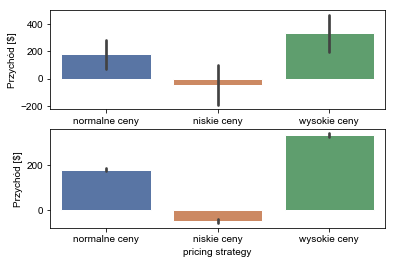

In [10]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(2, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "pricing strategy": 
            ["normalne ceny"] * n_simulations + 
            ["niskie ceny"] * n_simulations + 
            ["wysokie ceny"] * n_simulations,
        "Przychód [$]": np.concatenate((results_cheap, results_super_cheap, results_expensive), axis=0)
    }
)
ax = sns.barplot(x="pricing strategy", y="Przychód [$]", data=df_to_plot, ci="sd", ax=axes[0]) # standard diviation
ax = sns.barplot(x="pricing strategy", y="Przychód [$]", data=df_to_plot, ci=95, ax=axes[1]) # some bootstrap :D

<Figure size 1440x720 with 0 Axes>

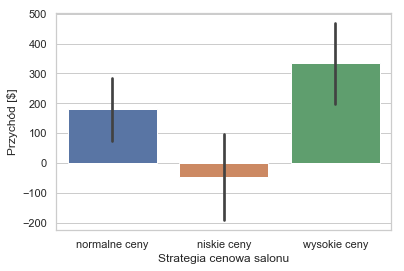

In [11]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Strategia cenowa salonu": 
            ["normalne ceny"] * n_simulations + 
            ["niskie ceny"] * n_simulations + 
            ["wysokie ceny"] * n_simulations,
        "Przychód [$]": np.concatenate((results_cheap, results_super_cheap, results_expensive), axis=0)
    }
)
ax = sns.barplot(x="Strategia cenowa salonu", y="Przychód [$]", data=df_to_plot, ci="sd")
plt.show()


## Zatrudnianie ładniejszych kelnerek

In [48]:
results_normal, _ = run_simulation(n_simulations=n_simulations)
results_beautiful, _ = run_simulation(n_simulations=n_simulations, flirt_time=25, avg_tip=5)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1440x720 with 0 Axes>

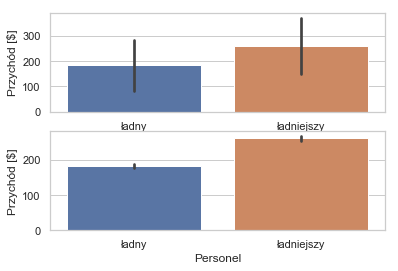

In [52]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(2, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Personel": 
            ["ładny"] * n_simulations + ["ładniejszy"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_beautiful), axis=0)
    }
)
ax = sns.barplot(x="Personel", y="Przychód [$]", data=df_to_plot, ci="sd", ax=axes[0]) # standard diviation
ax = sns.barplot(x="Personel", y="Przychód [$]", data=df_to_plot, ci=95, ax=axes[1]) # some bootstrap :D

<Figure size 1440x720 with 0 Axes>

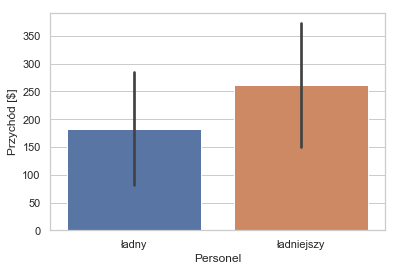

In [53]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Personel": 
            ["ładny"] * n_simulations + ["ładniejszy"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_beautiful), axis=0)
    }
)
ax = sns.barplot(x="Personel", y="Przychód [$]", data=df_to_plot, ci="sd")
plt.show()

In [54]:
print("średni przychód ładna: " + str(results_normal.mean()))
print("średni przychód ładniejsza: " + str(results_beautiful.mean()))

print("odchylenie ładna: " + str(results_normal.std()))
print("odchylenie ładniejsza: " + str(results_beautiful.std()))

średni przychód ładna: 183.28918593411288
średni przychód ładniejsza: 261.76085653603786
odchylenie ładna: 101.64650113119568
odchylenie ładniejsza: 111.1003849973026


## Zajęcie w kolejce

In [15]:
import tqdm
patience_results = np.zeros(11)

for patience in tqdm.tqdm(range(len(patience_results))):
    results, _ = run_simulation(n_simulations=int(n_simulations), patience_threshold=patience)
    patience_results[patience] = results.mean()

100%|██████████████████████████████████████████| 11/11 [00:28<00:00,  2.98s/it]


In [16]:
patience_results

array([ 33.34054161,  50.1671427 ,  71.62622251,  79.49505811,
       100.03825484, 116.06739843, 135.37563808, 137.36876476,
       150.9739477 , 155.56742623, 154.56740773])

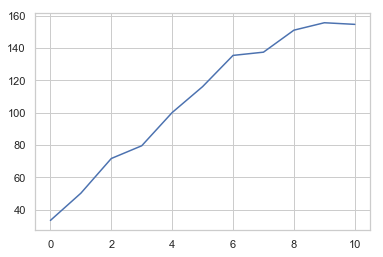

In [17]:
sns.set(style="whitegrid")
plt.plot(patience_results)
plt.show()

## Lepszy wystrój, więcej klientów, wyższa strata

In [18]:
import tqdm
decor_results = np.zeros(20)

for decor in tqdm.tqdm(range(1, len(decor_results))):
    results, _ = run_simulation(
        n_simulations=int(n_simulations/10), 
        shootout_loss=5*decor, 
        customer_lambda=(2*decor+5))
    decor_results[decor] = results.mean()

100%|██████████████████████████████████████████| 19/19 [00:08<00:00,  4.56it/s]


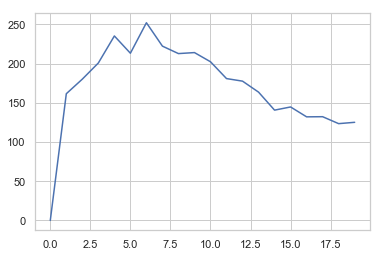

In [19]:
sns.set(style="whitegrid")
plt.plot(decor_results)
plt.show()

# Większe stoły do pokera

In [20]:
results_normal, _ = run_simulation(n_simulations=n_simulations)
results_1, _ = run_simulation(n_simulations=n_simulations, poker_table_size=6, poker_length=15)
results_2, _ = run_simulation(n_simulations=n_simulations, poker_table_size=7, poker_length=20)
results_3, _ = run_simulation(n_simulations=n_simulations, poker_table_size=8, poker_length=25)

<Figure size 1440x720 with 0 Axes>

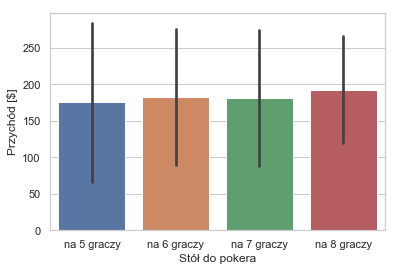

In [21]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Stół do pokera": 
            ["na 5 graczy"] * n_simulations + ["na 6 graczy"] * n_simulations + ["na 7 graczy"] * n_simulations + ["na 8 graczy"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_1, results_2, results_3), axis=0)
    }
)
ax = sns.barplot(x="Stół do pokera", y="Przychód [$]", data=df_to_plot, ci="sd") 
plt.show()

In [22]:
print("średni przychód normal: " + str(results_normal.mean()))
print("średni przychód 1: " + str(results_1.mean()))
print("średni przychód 2: " + str(results_2.mean()))
print("średni przychód 3: " + str(results_3.mean()))

print("odchylenie normal: " + str(results_normal.std()))
print("odchylenie przychód 1: " + str(results_1.std()))
print("odchylenie przychód 2: " + str(results_2.std()))
print("odchylenie przychód 3: " + str(results_3.std()))

średni przychód normal: 174.94766190097428
średni przychód 1: 182.52248615840037
średni przychód 2: 181.2229747546541
średni przychód 3: 192.47437270903657
odchylenie normal: 108.47388042483627
odchylenie przychód 1: 93.1193473326607
odchylenie przychód 2: 93.02462592976782
odchylenie przychód 3: 72.7865736815705
